In [1]:
import numpy as np
import os,glob,datetime,random,time
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Convolution2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, MaxPooling1D, Convolution1D, ZeroPadding2D,AveragePooling2D
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.utils.np_utils import to_categorical
import pandas as pd
from bokeh.plotting import output_file, show, figure, vplot

from __future__ import print_function

from keras import backend as theno
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
def get_img_from_win(img,win,img_row,img_col):
    if img.ndim==3:
        imgs=[]
        for win_index in range (0,len(win)):
            win_c= win[win_index]
            imgs.append(img_extend(img[win_c[1][0]:win_c[1][1],win_c[0][0]:win_c[0][1],:],img_row,img_col))
    if img.ndim==2:
        imgs=[]
        for win_index in range (0,len(win)):
            win_c= win[win_index]
            imgs.append(img[win_c[1][0]:win_c[1][1],win_c[0][0]:win_c[0][1]])
    return imgs    

def get_train_win(img):
    win=[]
#    win.append(np.array([[0,300],[0,300]]))   #win[0] x win[1] y
#    win.append(np.array([[0,300],[300,600]]))
#    win.append(np.array([[300,600],[0,300]]))
#    win.append(np.array([[300,600],[300,600]]))
#    win.append(np.array([[600,900],[0,300]]))
#    win.append(np.array([[600,900],[300,600]]))
    #win.append(np.array([[0,670],[0,670]]))
    win.append(np.array([[0,img.shape[1]],[0,img.shape[0]]]))
    return win,len(win)
    

In [3]:
def get_test_win(img):
    win=[]
    win.append(np.array([[0,img.shape[1]],[0,img.shape[0]]]))
  #  win.append(np.array([[0,800],[100,800]]))
    return win,len(win)    
    
def draw_win_in_ori(img,win,size):
    img_n=np.copy(img)
#    win_arr=np.array(win)
    for win_index in range(0,len(win)):
        win_c=win[win_index]

        img_n[win_c[1][0]:win_c[1][0]+size,win_c[0][0]:win_c[0][1],:]=0
        img_n[win_c[1][1]-size:win_c[1][1],win_c[0][0]:win_c[0][1],:]=0
        img_n[win_c[1][0]:win_c[1][1],win_c[0][0]:win_c[0][0]+size,:]=0
        img_n[win_c[1][0]:win_c[1][1],win_c[0][1]-size:win_c[0][1],:]=0
        
    plt.imshow(img_n)
    plt.imsave(os.path.join(result_file,'win_img_'+Script_name+"_"+file_time_global+'.png'),img_n)
    


In [4]:
def img_extend(img,img_rows,img_cols):
    half=int(np.floor(img_cols/2))
    part1=np.zeros((half,half,3),dtype='uint8')
    part2=np.zeros((half,img.shape[1],3),dtype='uint8')
    part3=np.zeros((half,half,3),dtype='uint8')
    part4=np.zeros((img.shape[0],half,3),dtype='uint8')
    part5=np.zeros((img.shape[0],half,3),dtype='uint8')
    part6=np.zeros((half,half,3),dtype='uint8')
    part7=np.zeros((half,img.shape[1],3),dtype='uint8')
    part8=np.zeros((half,half,3),dtype='uint8')
    part1[:,:,:]=img[0,0,:]
    part2[:,:,:]=np.reshape(img[0,:,:],(1,img.shape[1],3))
    part3[:,:,:]=img[0,img.shape[1]-1,:]
    part4[:,:,:]=np.reshape(img[:,0,:],(img.shape[0],1,3))
    part5[:,:,:]=np.reshape(img[:,img.shape[1]-1,:],(img.shape[0],1,3))
    part6[:,:,:]=img[img.shape[0]-1,0,:]
    part7[:,:,:]=np.reshape(img[img.shape[0]-1,:,:],(1,img.shape[1],3))
    part8[:,:,:]=img[img.shape[0]-1,img.shape[1]-1,:]
    
    img_up_all=np.zeros((half,half+half+img.shape[1],3),dtype='uint8')    
    img_mid_all=np.zeros((img.shape[0],half+half+img.shape[1],3),dtype='uint8')
    img_down_all=np.zeros((half,half+half+img.shape[1],3),dtype='uint8')    
    img_all=np.zeros((img.shape[0]+half*2,img.shape[1]+half*2,3),dtype='uint8')
    
    img_up_all=np.concatenate((part1,part2,part3),axis=1)
    img_mid_all=np.concatenate((part4,img,part5),axis=1)
    img_down_all=np.concatenate((part6,part7,part8),axis=1)
    img_all=np.concatenate((img_up_all,img_mid_all,img_down_all),axis=0)
    return img_all
    
  


In [5]:
def get_data_from_img(img,img_bin,img_rows,img_cols,Samp_Max,case):
    if case=='train':
        data=[]
        pos=[]
        neg=[]
        label=[]
        pos_label=[]
        neg_label=[]
        half=int(np.floor(img_cols/2))
        for row in range (half,img.shape[0]-half):
            for col in range (half,img.shape[1]-half):
                if img_bin[row-half][col-half]==255:
                    pos.append(img[row-half:row+half,col-half:col+half,:])
                    pos_label.append(img_bin[row-half][col-half])
                else:
                    neg.append(img[row-half:row+half,col-half:col+half,:])
                    neg_label.append(img_bin[row-half][col-half])  
        if len(neg)>Samp_Max:
            rand=random.sample(range(len(neg)),Samp_Max)
            neg_new=[]
            label_new=[]
            neg_new=[neg[x] for x in rand]
            label_new=[neg_label[x] for x in rand]
            neg=neg_new
            neg_label=label_new       
        data.extend(pos)
        data.extend(neg)
        label.extend(pos_label)
        label.extend(neg_label)
        
    if case =='test':
        data=[]
        label=[]
        half=int(np.floor(img_cols/2))
        for row in range (half,img.shape[0]-half):
            for col in range (half,img.shape[1]-half):
                data.append(img[row-half:row+half,col-half:col+half,:])
                label.append(img_bin[row-half][col-half])
        if len(data)>Samp_Max:
            print("Tested image is too large")      
    return data,label



In [6]:
def reshape_data(data):
    #reshape train or test images into  4D matric [number_of_samples,channels,rows,cols]

    data=np.transpose(data,(0,3,1,2))
    #convert dtype from int8 into float32
    data = data.astype('float32')
    #assign values to [0,1]
    data = (data-127)/128

    return data 
    


In [7]:
def create_model(img_rows,img_cols):
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(img_rows, img_cols,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="tf"))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="tf"))

    #model.add(Convolution2D(128, 3, 3))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="tf"))
    
    #model.add(Convolution2D(256, 3, 3))
   # model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="tf"))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    return model  
   
def save_model(model):
    json_string=model.to_json()
    if not os.path.isdir(models_file):
        os.mkdir(models_file)
    modle_path=os.path.join(models_file,'architecture'+'_'+file_time_global+'.json')
    open(modle_path,'w').write(json_string)
    model.save_weights(os.path.join(models_file,'model_weights'+'_'+ file_time_global+'.h5'),overwrite= True )
    
def read_model():
    model=model_from_json(open(os.path.join(models_file,'architecture'+'_'+ file_time_global+'.json')).read())
    model.load_weights(os.path.join(models_file,'model_weights'+'_'+file_time_global+'.h5'))
    return model

In [8]:
def acc_loss_visual(history):
    acc_arr=np.array(history['acc'],dtype=float)
    loss_arr=np.array(history['loss'],dtype=float)
    val_acc_arr=np.array(history['val_acc'],dtype=float)
    val_loss_arr=np.array(history['val_loss'],dtype=float)
    output_file(os.path.join(result_file,"legends_"+Script_name+"_"+file_time_global+".html"))
    p1 = figure()
    p1.title = "Training and Cross validation accuracy"
    p1.xaxis.axis_label = 'Iterations'
    p1.yaxis.axis_label = 'Accuracy'
    p1.circle(range(0,len(acc_arr)), acc_arr,color="green", legend="Train_Acc")
    p1.line(range(0,len(acc_arr)), acc_arr,line_color="green", legend="Train_Acc")
    p1.circle(range(0,len(val_acc_arr)), val_acc_arr,color="orange", legend="Val_Acc")
    p1.line(range(0,len(val_acc_arr)), val_acc_arr, line_color="orange",legend="Val_Acc")
    p2 = figure()
    p2.title = "Training and Cross validation loss_error"
    p2.xaxis.axis_label = 'Iterations'
    p2.yaxis.axis_label = 'Loss_error'
    p2.circle(range(0,len(loss_arr)), loss_arr,color="green", legend="Train_loss")
    p2.line(range(0,len(loss_arr)), loss_arr,line_color="green", legend="Train_loss")
    p2.circle(range(0,len(val_loss_arr)), val_loss_arr,color="orange", legend="Val_loss")
    p2.line(range(0,len(val_loss_arr)), val_loss_arr, line_color="orange",legend="Val_loss")
    plt.plot(p1,'-o')
    plt.plot(p2,'-o')
    plt.show()

def result_2_img(predict,img,img_rows,img_cols):
    raw_img=predict.reshape(img.shape[0],img.shape[1])
    #raw_img=predict.reshape(800,700)
#    pre_img=np.zeros((img.shape[0],img.shape[1]))
#    half=int(np.floor(img_cols/2))
#    pre_img[half:(img.shape[0]-half+1),half:(img.shape[1]-half)+1]=raw_img
    return raw_img
    
def comp_mask_imgs(pre_img,ori_bin):
    #rows=800
    #cols=700 
    rows=ori_bin.shape[0]
    cols=ori_bin.shape[1]   
    color_img=np.zeros((rows,cols,3))
    nan_p=np.isnan(ori_bin)
    ori_bin=ori_bin/255
    mask_img_r=np.zeros((rows,cols))
    mask_img_g=np.zeros((rows,cols))
    mask_img_b=np.zeros((rows,cols))
#    mask_img=mask_img.reshape((ori_bin.shape[0]*ori_bin.shape[1],))
    mask_img_g[([pre_img==ori_bin]&(pre_img==1)).reshape((rows,cols))]=255  #TP
    color_img[:,:,1]=mask_img_g
    mask_img_b[([pre_img!=ori_bin]&(pre_img==1)).reshape((rows,cols))]=255  #FP
    color_img[:,:,2]=mask_img_b
    mask_img_r[([pre_img!=ori_bin]&(pre_img==0)).reshape((rows,cols))]=255  #FN
    color_img[:,:,0]=mask_img_r
    color_img[nan_p,:]=127    # U-known
    color_img/=255
    plt.imshow(color_img)
    plt.imsave(os.path.join(result_file,'Masked_'+Script_name+"_"+file_time_global+'.png'),color_img)
    return color_img   
    
def enhance_con_matrix(con_mat,pre):
    if con_mat.size==1:
        if np.unique(pre)==0:
            con_mat=np.array([[con_mat[0][0],0],[0,0]])
        else:
            con_mat=np.array([[0,0],[0,con_mat[0][0]]])
    return con_mat        


In [9]:
###########  file colation and globle V  ###########
#img_rows=18
#img_cols=18
img_rows=18
img_cols=18
n_procs=10
Samp_Max=50000
batch_size=100
nb_epoch=200
thresh=0.5 

In [10]:
Script_name=a=os.path.basename('.')
result_file=os.path.join('..','result')
models_file=os.path.join('..','models')
data_file=os.path.join('..','data')
now_global=datetime.datetime.now()
file_time_global=str(now_global.strftime("%Y-%m-%d-%H-%M"))    
   

In [11]:
ori_img=plt.imread(os.path.join(data_file,'b2.tif'))
ori_bin_img=plt.imread(os.path.join(data_file,'b2_layer.tif'))
ori_bin_img = ori_bin_img * 255
win ,nb_win=get_train_win(ori_img)
print("{} windows are chosen as training data, as follows".format(nb_win))

draw_win_in_ori(ori_img,win,3)    

imgs=get_img_from_win(ori_img,win,img_rows,img_cols)
imgs_bin=get_img_from_win(ori_bin_img,win,img_rows,img_cols)


1 windows are chosen as training data, as follows


In [12]:
############################ get train data and label ############################


#test_win=[]
#test_win.append(np.array([[0,ori_img.shape[1]],[0,ori_img.shape[0]]]))

X_T=[]
y_T=[]
for i in range (0,len(imgs)):
    Train_data,Train_label=get_data_from_img(imgs[i],imgs_bin  [i],img_rows,img_cols,Samp_Max,'train')
    X_T.extend(Train_data)
    y_T.extend(Train_label)

shuffle=random.sample(range(len(X_T)),len(X_T))
train_data=[]
train_data=[X_T[x] for x in shuffle]
labels=[]
labels=[y_T[x] for x in shuffle]

train_data=np.array(train_data)  
train_data=reshape_data(train_data)  

labels=np.array(labels)/255

#labels = np.array([int(x) for x in labels],dtype=int)
#labels  = to_categorical(labels )
X_train,X_valid,y_train,y_valid=train_test_split(train_data,labels,test_size=0.2,random_state=42) 
pos_num=list(y_train).count(1)
neg_num=list(y_train).count(0)

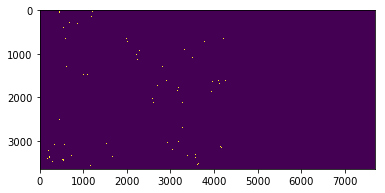

In [13]:
plt.imshow(ori_bin_img)
plt.show()

In [14]:
############################ get testing data and label ############################
test_img=plt.imread(os.path.join(data_file,'B_image2.tif'))
test_bin_img=plt.imread(os.path.join(data_file,'B_label2.tif'))
test_bin_img = test_bin_img * 255
test_win,nb_test_win=get_test_win(test_img)
print("{} windows are chosen as testing data, as follows".format(nb_win))


1 windows are chosen as testing data, as follows


In [15]:
############################ get testing data and label ############################
#test_win,nb_test_win=get_test_win(test_img)
test_imgs=get_img_from_win(test_img,test_win,img_rows,img_cols)
test_imgs_bin=get_img_from_win(test_bin_img,test_win,img_rows,img_cols)
test_data,test_label=get_data_from_img(test_imgs[0],test_imgs_bin[0],img_rows,img_cols,1000000000,'test')

test_data=np.array(test_data) 
#test_data= test_data[0:200000] 
test_data=reshape_data(test_data) 
test_label=np.array(test_label)/255

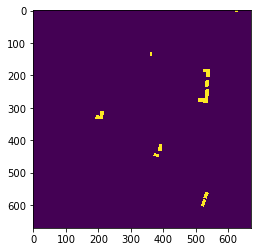

In [16]:
plt.imshow(test_bin_img)
plt.show()

In [17]:
#################################################################################

print("Start Mission!!")
print('Split {} samples into:'.format(len(X_train)+len(X_valid)))
print('      training samples:', len(X_train))
print('      validation samples: ', len(X_valid))
print('pos_num:{}  neg_num:{}'.format(pos_num,neg_num)) 
model = create_model(img_rows,img_cols)
save_model(model)
read_model()

Start Mission!!
Split 84156 samples into:
      training samples: 67324
      validation samples:  16832
pos_num:27284  neg_num:40040


/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(18, 18, 3...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_last", pool_size=(2, 2))`
  """
/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  import sys
/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_last", pool_size=(2, 2))`
  if __name__ == '__main__':


In [18]:



################################# Training  ###########
time1=time.time()

X_train= X_train.reshape(X_train.shape[0],img_cols, img_rows,3)
X_valid= X_valid.reshape(X_valid.shape[0], img_cols,img_rows,3)
train_data=train_data.reshape(train_data.shape[0],img_cols,img_rows,3)



In [19]:
History=model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_data=(X_valid, y_valid))  
time2=time.time()

/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 67324 samples, validate on 16832 samples
Epoch 1/200
67324/67324 [==============================] - 7s - loss: 0.1820 - acc: 0.9331 - val_loss: 0.1327 - val_acc: 0.9512
Epoch 2/200
67324/67324 [==============================] - 7s - loss: 0.1220 - acc: 0.9540 - val_loss: 0.1422 - val_acc: 0.9425
Epoch 3/200
67324/67324 [==============================] - 7s - loss: 0.0948 - acc: 0.9645 - val_loss: 0.0752 - val_acc: 0.9719
Epoch 4/200
67324/67324 [==============================] - 6s - loss: 0.0800 - acc: 0.9707 - val_loss: 0.0654 - val_acc: 0.9773
Epoch 5/200
67324/67324 [==============================] - 6s - loss: 0.0700 - acc: 0.9753 - val_loss: 0.0684 - val_acc: 0.9737
Epoch 6/200
67324/67324 [==============================] - 6s - loss: 0.0644 - acc: 0.9788 - val_loss: 0.0599 - val_acc: 0.9816
Epoch 7/200
67324/67324 [==============================] - 6s - loss: 0.0569 - acc: 0.9808 - val_loss: 0.1510 - val_acc: 0.9633
Epoch 8/200
67324/67324 [=============================

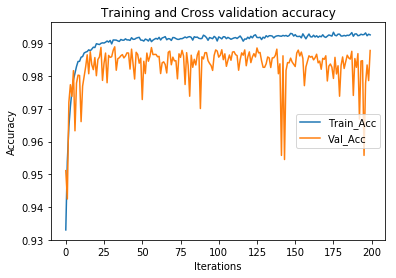

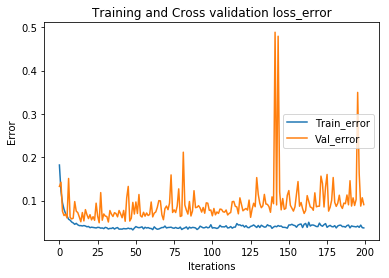

In [20]:
history= History.history
acc_arr=np.array(history['acc'],dtype=float)
loss_arr=np.array(history['loss'],dtype=float)
val_acc_arr=np.array(history['val_acc'],dtype=float)
val_loss_arr=np.array(history['val_loss'],dtype=float)
iternation= range(0, len(val_loss_arr))
#fig=plt.figure()
fig, p1 = plt.subplots()
p1.set_xlabel('Iterations')
p1.set_ylabel('Accuracy')
p1.set_title('Training and Cross validation accuracy')
p1.plot(range(0,len(acc_arr)), acc_arr, label="Train_Acc")
p1.plot(range(0,len(val_acc_arr)), val_acc_arr, label="Val_Acc")
p1.legend(loc=5)

fig, p2 = plt.subplots()
p2.set_xlabel('Iterations')
p2.set_ylabel('Error')
p2.set_title('Training and Cross validation loss_error')
p2.plot(range(0,len(loss_arr)), loss_arr, label="Train_error")
p2.plot(range(0,len(val_loss_arr)), val_loss_arr, label="Val_error")
p2.legend(loc=5)
plt.show()

In [21]:
print('training time:{}s'.format(time2-time1))
#acc_loss_visual(History.history)

train_pred_raw = model.predict(train_data, batch_size=1000, verbose=1)
train_pred=np.copy(train_pred_raw)
train_pred[train_pred[:]<thresh]=0
train_pred[train_pred[:]>=thresh]=1

print("Training result:")
train_con=confusion_matrix(labels, train_pred)
train_con=enhance_con_matrix(train_con,train_pred)
train_acc=accuracy_score(labels, train_pred)
train_kap=cohen_kappa_score(labels, train_pred)
print("Confusion Matrix:")
print(str(train_con[0][0])+'   '+str(train_con[0][1]))
print(str(train_con[1][0])+'   '+str(train_con[1][1]))
print("Accuracy: {0:.4f}".format(train_acc))
print("Kappa: {0:.4f}\n".format(train_kap))

training time:1426.3249871730804s
84156/84156 [==============================] - 1s     
Training result:
Confusion Matrix:
49742   258
85   34071
Accuracy: 0.9959
Kappa: 0.9916



In [22]:
##################################  testing #############
print('Number of testing samples:{}'.format(len(test_data)))
print('Start testing!')
time3=time.time()
test_data=test_data.reshape(test_data.shape[0],img_cols,img_rows,3)
test_pred_raw = model.predict(test_data, batch_size=1000, verbose=1)
test_pred=np.copy(test_pred_raw)
test_pred[test_pred[:]<thresh]=0
test_pred[test_pred[:]>=thresh]=1
time4=time.time()
print('Testing time:{}s'.format(time4-time3))

print("Testing result:")
test_con=confusion_matrix(test_label, test_pred)
test_con=enhance_con_matrix(test_con,test_pred)
test_acc=accuracy_score(test_label, test_pred)
test_kap=cohen_kappa_score(test_label, test_pred)
print("Confusion Matrix:")
print(str(test_con[0][0])+'   '+str(test_con[0][1]))
print(str(test_con[1][0])+'   '+str(test_con[1][1]))
print("Accuracy: {0:.4f}".format(test_acc))
print("Kappa: {0:.4f}\n".format(test_kap))
print("Compared with original\n".format(test_kap))

pre_img=result_2_img(test_pred,test_bin_img,img_rows,img_cols)
comp_mask_imgs(pre_img,test_bin_img)

Number of testing samples:448900
Start testing!
448900/448900 [==============================] - 7s     
Testing time:7.5102620124816895s
Testing result:
Confusion Matrix:
433772   12365
316   2447
Accuracy: 0.9718
Kappa: 0.2709

Compared with original



array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,

In [23]:
inputs = Input(( img_rows, img_cols,3))
conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

up6 = merge([Convolution2D(256, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv5)), conv4], mode='concat', concat_axis=1)
conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv6)
model = Model(input=inputs, output=conv10)
model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics = ['accuracy'])

/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  
/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  import sys
/home/uttam/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel